In [1]:
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import math
import os
import cv2
import json
import re
import numpy as np
import random
from timeit import default_timer as timer
from pprint import pprint
from torch.autograd import Variable
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from ipywidgets import FloatProgress
from IPython.display import display

USE_CUDA=True

%matplotlib inline

class VGG(nn.Module):

   def __init__(self, features, num_classes=2):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512*2*2, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        self._initialize_weights()

   def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        #print(x.size())
        x = self.classifier(x)
        return F.softmax(x)

   def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

In [2]:
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 1
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [3]:
def vgg16(pretrained=False, **kwargs):
    """VGG 16-layer model (configuration "D")

   Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = VGG(make_layers(cfg['D']), **kwargs)
    if USE_CUDA:
        model = model.cuda()
        
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg16']))
    return model

In [4]:
def vgg16_bn(pretrained=False, **kwargs):
    """VGG 16-layer model (configuration "D") with batch normalization

   Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = VGG(make_layers(cfg['D'], batch_norm=True), **kwargs)
    if USE_CUDA:
        model = model.cuda()
        
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg16_bn']))
    return model

In [5]:
vgg = vgg16_bn()
if USE_CUDA:
    vgg = vgg.cuda()
    
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(vgg.parameters(), lr=0.001, momentum=0.9)

In [6]:
# Create dataloader
POS_SAMPLE_DIRS = ["pos_moles/cropped/"]
NEG_SAMPLE_DIRS = ["neg_moles/cropped/", "neg_caltech/cropped/"]

DATA_COLLECTION_ROOT = "../data_collection/"

POS_SAMPLE_DIRS = [DATA_COLLECTION_ROOT + d for d in POS_SAMPLE_DIRS]
NEG_SAMPLE_DIRS = [DATA_COLLECTION_ROOT + d for d in NEG_SAMPLE_DIRS]

print("Collecting samples...")
# Collect samples and sort them into positive and negative
pos_paths = []
neg_paths = []
for sample_dir in POS_SAMPLE_DIRS:
    for path in os.listdir(sample_dir):
        if path.endswith(".png"):
            pos_paths.append(sample_dir + path)

for sample_dir in NEG_SAMPLE_DIRS:
    for path in os.listdir(sample_dir):
        if path.endswith(".png"):
            neg_paths.append(sample_dir + path)

# Oversample positives to make up for unbalanced data
pos_neg_diff = len(neg_paths) - len(pos_paths)
repl_i = random.sample(range(0, len(pos_paths)), pos_neg_diff)
for i in repl_i:
    pos_paths.append(pos_paths[i])

# Limit sample sizes for quicker testing
pos_paths = pos_paths
neg_paths = neg_paths
        
sample_img_shape = cv2.imread(pos_paths[0]).shape
print("Image shape: %d x %d x %d" % sample_img_shape)
#sis_flat = cv2.imread(pos_paths[0]).flatten().shape

num_samples = 0

# to optimize memory, preallocate np arrays
for img_path in pos_paths:
    img = cv2.imread(img_path)
    if img.shape == sample_img_shape:
        num_samples += 1

for img_path in neg_paths:
    img = cv2.imread(img_path)
    if img.shape == sample_img_shape:
        num_samples += 1

x_size = (num_samples, sample_img_shape[0], sample_img_shape[1], sample_img_shape[2])
y_size = (num_samples, 2)

all_x = np.zeros(x_size, dtype=np.uint8)
all_y = np.zeros(y_size, dtype=np.uint8)

sample_i = 0
for img_path in pos_paths:
    img = cv2.imread(img_path)
    if img.shape == sample_img_shape:
        all_x[sample_i] = img
        all_y[sample_i] = np.array([0,1])
        sample_i += 1

for img_path in neg_paths:
    img = cv2.imread(img_path)
    if img.shape == sample_img_shape:    
        all_x[sample_i] = img
        all_y[sample_i] = np.array([1,0])
        sample_i += 1

print("Collected %d samples!" % num_samples)

Image shape: 64 x 64 x 3
Collected 10268 samples!


In [16]:
# Create dataloader
train_dataset = []
for i in range(len(all_x)):
    img = cv2.cvtColor(all_x[i], cv2.COLOR_BGR2GRAY)
    img = cv2.normalize(img, img, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    train_dataset.append({'predicted': img, 'ground_truth': all_y[i]})
    
dataloader = DataLoader(train_dataset, batch_size=4,
                        shuffle=True, num_workers=8)

In [17]:
#plt.imshow(train_dataset[1]['predicted'], cmap='gray')
#plt.show()

In [18]:
max_epoch = 10
# max_epoch = 100

# Just a progress bar
# If it doesn't load (js error), run this in terminal then restart jupyter:
# jupyter nbextension enable --py --sys-prefix widgetsnbextension
f = FloatProgress(min=0, max=max_epoch*len(dataloader))
display(f)
start = timer()
for epoch in range(max_epoch):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        # get the inputs
        inputs, labels = data['predicted'], data['ground_truth']

       # wrap them in Variable
        if USE_CUDA:
            inputs, targets = Variable(inputs.cuda().float()).view(-1,1,64,64), \
                         Variable(labels.cuda().float()).view(-1, 2)
        else:
            inputs, targets = Variable(inputs.float()).view(-1,1,64,64), \
                         Variable(labels.float()).view(-1, 2)

       # zero the parameter gradients
        optimizer.zero_grad()

       # forward + backward + optimize
        if USE_CUDA:
            outputs = vgg(inputs).cuda()
        else:
            outputs = vgg(inputs)

        #print("----------------------\nOutputs:")
        #print(outputs)
        #print("\nTargets:")
        #print(targets)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
            
       # print statistics
        running_loss += loss.data[0]
        #print(running_loss)
        #if i % 2000 == 1999:    # print every 2000 mini-batches
            #print('[%d, %5d] loss: %.3f' %
            #      (epoch + 1, i + 1, running_loss / 2000))
            #running_loss = 0.0
        f.value += 1
    # print loss at the end of each epoch
    print("Epoch %d Loss: %.3f" % (epoch+1, running_loss / 2000))
f.close()
end = timer()
elapsed = int(end-start)
hours = elapsed/3600
minutes = (elapsed % 3600) / 60
seconds = elapsed % 60
print("Finished Training - Runtime %d:%d:%d" % (hours, minutes, seconds))


A Jupyter Widget

Process Process-7:
Process Process-1:
Process Process-4:
Process Process-6:
Process Process-8:
Process Process-3:
Process Process-5:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-2:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/ubuntu/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda2/lib/python2.7/mul

KeyboardInterrupt: 

KeyboardInterrupt
  File "/home/ubuntu/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/home/ubuntu/anaconda2/lib/python2.7/multiprocessing/queues.py", line 374, in get
    racquire()
KeyboardInterrupt


In [19]:
# ... after training, save your model 
#torch.save(vgg.state_dict(), 'resources/models/mole_VGG_v2.pth')
#print("Model saved!")

In [12]:
# Load Testing Data
THRESH = 0.99
TRIAL = "46"
TRIAL_DIR = "./resources/trials/" + TRIAL

test_dataset = []
results = {0: [], 1:[], -1: []}
raw_paths = os.listdir(TRIAL_DIR)
for path in raw_paths:
    if not path.startswith("full_face") and path.endswith(".jpg"):
        img = cv2.imread(TRIAL_DIR + "/" + path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.normalize(img, img, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        
        # Test each image
        test_dataset.append({'predicted': img, 'ground_truth': np.array([0, 0]).T, 'path': path})


dataloader = DataLoader(test_dataset, batch_size=1,
                        shuffle=True, num_workers=8)
vgg.eval()

test = None
for i, data in enumerate(dataloader):
    # get the inputs
    inputs, labels, path = data['predicted'], data['ground_truth'], data['path'][0]
        
    # wrap them in Variable
    if USE_CUDA:
        inputs, targets = Variable(inputs.cuda().float()).view(-1,1,64,64), \
                    Variable(labels.cuda().float()).view(-1, 2)
    else:
        inputs, targets = Variable(inputs.float()).view(-1,1,64,64), \
                    Variable(labels.float()).view(-1, 2)


    # forward + backward + optimize
    if USE_CUDA:
        test_outputs = vgg(inputs).cuda()
        np_outputs = test_outputs.data.cpu().numpy()
    else:
        test_outputs = vgg(inputs)
        np_outputs = test_outputs.data.numpy()

    if np_outputs[0][1] >= THRESH:
        results[1].append([path, np_outputs[0][1]])
    else:
        results[0].append([path, np_outputs[0][1]])

#with open("vgg_filter_results.json",'w') as f:
#    json.dump(results, f)

In [15]:
results[1].sort(key=lambda x: x[1], reverse=True)
filtered_results = []
for r in results[1]:
    coords = re.search("x([0-9]*)_y([0-9]*).jpg", r[0])
    x = int(coords.group(1))
    y = int(coords.group(2))
    if x > 650 and x < 2400 and y > 0 and y < 2404: 
        filtered_results.append(r)
pprint(filtered_results)
print("\nCOUNTS\n0:%d\n1:%d,E:%d" % (len(results[0]), len(results[1]), len(results[-1])))

[['x1266_y742.jpg', 0.99999249],
 ['x2111_y1898.jpg', 0.99998772],
 ['x995_y1822.jpg', 0.99998772],
 ['x2040_y825.jpg', 0.99997544],
 ['x2039_y911.jpg', 0.99990976],
 ['x1817_y891.jpg', 0.99823487],
 ['x1589_y2137.jpg', 0.99720746]]

COUNTS
0:328
1:8,E:0


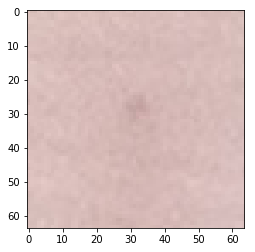

['x1266_y742.jpg', 0.99999249]


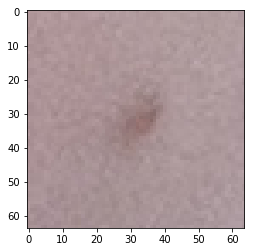

['x2111_y1898.jpg', 0.99998772]


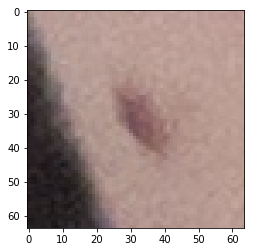

['x995_y1822.jpg', 0.99998772]


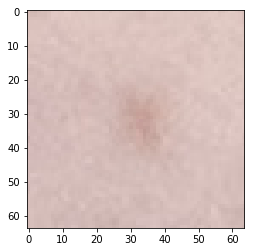

['x2040_y825.jpg', 0.99997544]


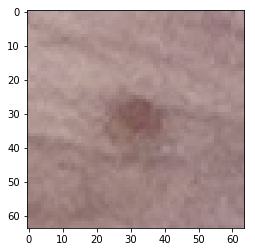

['x2039_y911.jpg', 0.99990976]


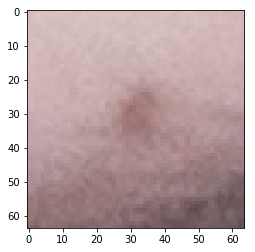

['x1817_y891.jpg', 0.99823487]


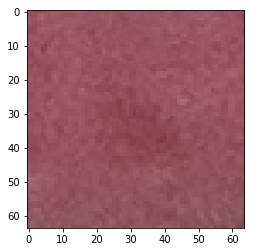

['x1589_y2137.jpg', 0.99720746]


In [16]:
for r in filtered_results:
    img = cv2.imread(TRIAL_DIR + "/" + r[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img, cmap='gray')
    plt.show()
    print r

In [7]:
# .. to load your previously training model:
vgg.load_state_dict(torch.load('resources/models/mole_VGG_v2.pth'))